#Mini Project 3 - Satu Laukkanen

##Dataframe Creation and Visual Data Analysis

In [136]:
import pandas as pd

In [137]:
import os
from google.colab import drive
drive.mount('/content/drive')

#please update your own file path here
folder_path = '/content/drive/My Drive/Machine Learning/Mini Project 3'
files = os.listdir(folder_path)
print(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['NIR_Data.xlsx', 'NIR_Data.csv', 'NIR_Data.gsheet', 'Attempt1.ipynb', 'Attempt2.ipynb', 'Attempt3.ipynb', 'Attempt4.ipynb', 'Attempt5.ipynb', 'Attempt6.ipynb', 'Attempt8.ipynb', 'Attempt7.ipynb']


In [138]:
df = pd.read_excel(folder_path + '/' + 'NIR_Data.xlsx')

#ID and round extracted for easier handling
df['SampleID_Base'] = df['Sample ID'].str.extract(r'(\d+)').astype(int) #extract sample ID, like 3001
df['Spectral_Round'] = df['Sample ID'].str.extract(r'(\d+)$').astype(int) #extract spectral round

#set an ID col as index
df.rename(columns={'Unnamed: 1': 'ID'}, inplace=True)
df.set_index('ID', inplace=True)

df.drop(columns=['Sample ID'], inplace=True)

df = df[['SampleID_Base', 'Spectral_Round'] + [col for col in df.columns if col not in ['SampleID_Base', 'Spectral_Round']]]

# Convert all column names to strings using map
df.columns = df.columns.map(str)

df.head()

,SampleID_Base,Spectral_Round,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,...,4057.888,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture
ID,,,,,,,,,,,,,,,,,,,,,
1,3001,0,0.430391,0.430351,0.430570,0.430974,0.431129,0.430807,0.430425,0.430264,...,1.042346,1.052940,1.062511,1.070474,1.077419,1.082571,1.084933,1.086961,1.088756,24.933532
2,3001,1,0.418378,0.418387,0.418783,0.418983,0.418721,0.418339,0.417951,0.417494,...,1.017335,1.027128,1.036592,1.043992,1.049032,1.051711,1.052812,1.054065,1.055364,24.933532
3,3001,2,0.446782,0.446930,0.446840,0.446419,0.446009,0.445715,0.445539,0.445537,...,1.053265,1.061849,1.070649,1.079960,1.088810,1.094708,1.098719,1.100796,1.099144,24.933532
4,3001,3,0.434038,0.433805,0.433692,0.433850,0.433912,0.433757,0.433515,0.433327,...,1.020629,1.029372,1.038613,1.047470,1.053009,1.054695,1.054589,1.053924,1.053708,24.933532
5,3001,4,0.451491,0.451441,0.451692,0.451816,0.451755,0.451595,0.451293,0.451114,...,1.013404,1.023107,1.030855,1.036464,1.042622,1.049984,1.055300,1.055122,1.052386,24.933532


The dataframe has 773 rows and 1040 columns.

In [139]:
df.shape

(773, 1040)

It has zero null values.

In [140]:
df.isna().sum()

,0
SampleID_Base,0
Spectral_Round,0
11988.51,0
11980.8,0
11973.08,0
...,...
4019.315,0
4011.601,0
4003.886,0
3996.171,0


In [141]:
df.dtypes

,0
SampleID_Base,int64
Spectral_Round,int64
11988.51,float64
11980.8,float64
11973.08,float64
...,...
4019.315,float64
4011.601,float64
4003.886,float64
3996.171,float64


Most samples have 5 spectral ronds, a 12 have 6 rounds, 11 have 7 rounds.

In [142]:
#variation in Spectral_Round values
df['Spectral_Round'].value_counts()

,count
Spectral_Round,
0,125
1,125
2,125
3,125
4,125
5,125
6,12
7,11


Brief look on the target moisture variable.

In [143]:
print(f"Moisture Range: {df['Moisture'].min()} to {df['Moisture'].max()}")
print(f"Mean Moisture: {df['Moisture'].mean():.2f}")
print(f"Standard Deviation: {df['Moisture'].std():.2f}")


Moisture Range: 17.981283422459878 to 73.0669499203349
Mean Moisture: 45.92
Standard Deviation: 14.44


##Outlier Detection and Visualization

Here, we can see a sample picked at random with all spectral rounds as their own line in a plot.

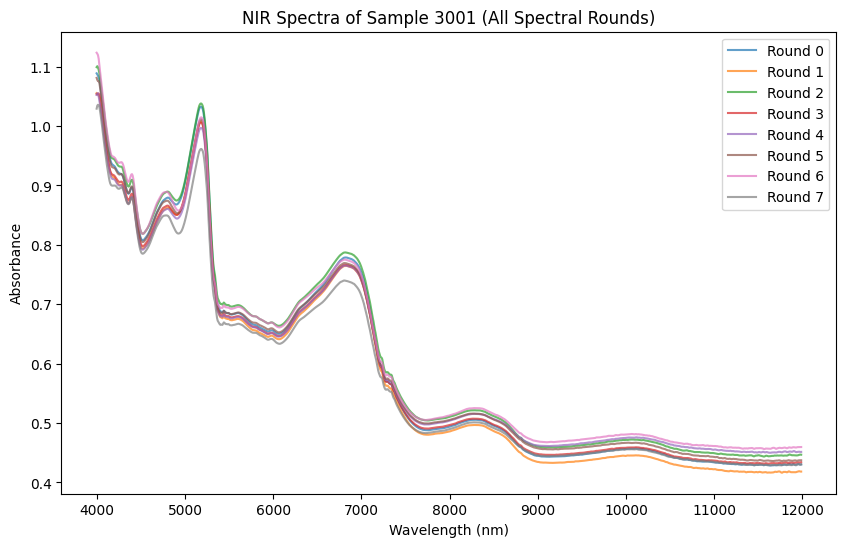

In [144]:
import matplotlib.pyplot as plt

sample_id = 3001
sample_data = df[df["SampleID_Base"] == sample_id].copy()  # Copy to avoid modifying original

spectral_rounds = sample_data["Spectral_Round"]

# Drop non-spectral columns, including "Outlier_Flag" if present
non_spectral_cols = ["SampleID_Base", "Spectral_Round", "Moisture", "Outlier_Flag"]
sample_data = sample_data.drop(columns=[col for col in non_spectral_cols if col in sample_data.columns])

# Convert column names (wavelengths) to float
wavelengths = sample_data.columns.astype(float)

# Plot all spectral rounds for this sample
plt.figure(figsize=(10, 6))
for i, row in enumerate(sample_data.values):
    plt.plot(wavelengths, row, alpha=0.7, label=f"Round {spectral_rounds.iloc[i]}")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title(f"NIR Spectra of Sample {sample_id} (All Spectral Rounds)")
plt.legend()
plt.show()


Now that we have some understanding of how one sample with mutliple spectral rounds looks like, it is time to look at the outliers. Outliers are detected by looking at the Z-score with an low 2 treshold and an example is flagged as an outlier if 10 or more measurements are flagged as outliers.

In [145]:
import numpy as np

mean_spectra = df.iloc[:, 2:].mean() #average absorbace at each wavelength
std_spectra = df.iloc[:, 2:].std() #standard deviation at each wavelength

#Z-score for each wave length
z_scores = ((df.iloc[:, 2:] - mean_spectra) / std_spectra).abs()
outliers = z_scores > 2 #Z-score over 2

#amount of flags an outlier has
outlier_counts = outliers.sum(axis=1)
df["Outlier_Flag"] = outlier_counts > 10

df[df["Outlier_Flag"]]

,SampleID_Base,Spectral_Round,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,...,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture,Outlier_Flag
ID,,,,,,,,,,,,,,,,,,,,,
89,3015,0,0.522589,0.522555,0.522460,0.522385,0.522381,0.522155,0.521628,0.521379,...,1.889877,1.906156,1.918702,1.922229,1.922297,1.936486,1.954305,1.952439,60.770808,True
90,3015,1,0.536199,0.535878,0.535901,0.536168,0.535863,0.535065,0.534343,0.534217,...,1.873671,1.876717,1.884776,1.904595,1.920807,1.918863,1.921662,1.936499,60.770808,True
92,3015,3,0.665179,0.665365,0.665328,0.664951,0.664706,0.664634,0.664218,0.663579,...,1.740603,1.758295,1.785992,1.801688,1.798541,1.787650,1.780497,1.783525,60.770808,True
94,3015,5,0.593650,0.593278,0.593206,0.593465,0.593861,0.593869,0.593016,0.591865,...,1.740429,1.753469,1.763785,1.769825,1.781586,1.806360,1.832024,1.837735,60.770808,True
372,3060,2,0.953560,0.953382,0.953270,0.951988,0.951471,0.952136,0.951658,0.949692,...,1.766419,1.776094,1.790242,1.808191,1.824454,1.828433,1.821324,1.822100,68.005545,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,3135,1,0.454908,0.454493,0.454070,0.453946,0.454072,0.454555,0.455412,0.456233,...,2.046067,2.053835,2.060408,2.058640,2.047520,2.055645,2.086929,2.089937,71.360682,True
832,3135,2,0.472922,0.473458,0.473622,0.473297,0.473046,0.473324,0.473977,0.474621,...,2.079082,2.090781,2.105335,2.119402,2.135707,2.149875,2.150397,2.140048,71.360682,True
833,3135,3,0.479655,0.479479,0.479343,0.479350,0.479754,0.480217,0.480448,0.480668,...,2.044991,2.065368,2.086045,2.112647,2.126044,2.123115,2.138850,2.178215,71.360682,True


Construct a list of the outlier examples.

In [146]:
outlier_sample_ids = df[df["Outlier_Flag"]]["SampleID_Base"].unique().tolist()
print(outlier_sample_ids)

[3015, 3060, 3061, 3062, 3063, 3064, 3066, 3069, 3070, 3076, 3077, 3090, 3092, 3093, 3095, 3096, 3099, 3120, 3130, 3134, 3135]


An example of an outlier, all spectral layers plotted. Compared to example 3001, 3070 has a higher absorbance at corresponding wavelengths.

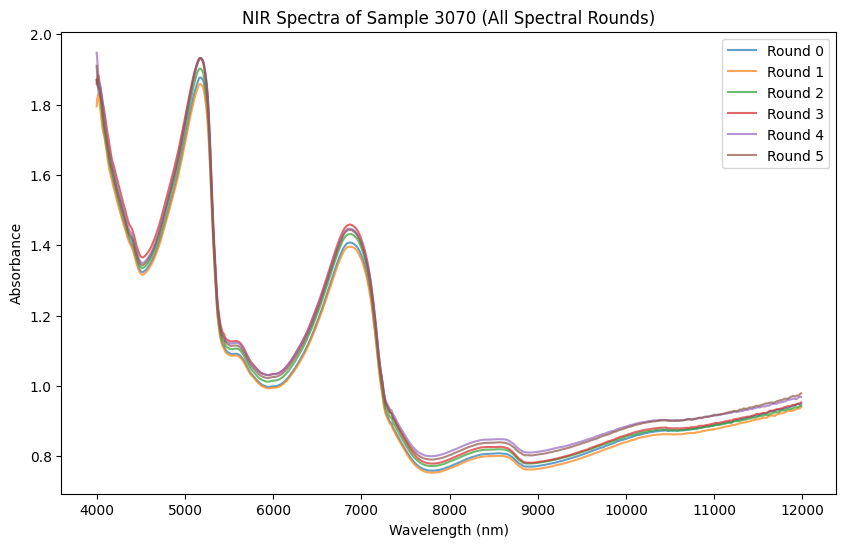

In [147]:
sample_id = 3070
sample_data = df[df["SampleID_Base"] == sample_id].copy()

spectral_rounds = sample_data["Spectral_Round"]

non_spectral_cols = ["SampleID_Base", "Spectral_Round", "Moisture", "Outlier_Flag"]
sample_data = sample_data.drop(columns=[col for col in non_spectral_cols if col in sample_data.columns])

#convert column names to float
wavelengths = sample_data.columns.astype(float)

plt.figure(figsize=(10, 6))
for i, row in enumerate(sample_data.values):
    plt.plot(wavelengths, row, alpha=0.7, label=f"Round {spectral_rounds.iloc[i]}")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.title(f"NIR Spectra of Sample {sample_id} (All Spectral Rounds)")
plt.legend()
plt.show()


In the following graph, the mean for each spectral round for each sample is calculated. All outlier examples are then plotted in a graph.

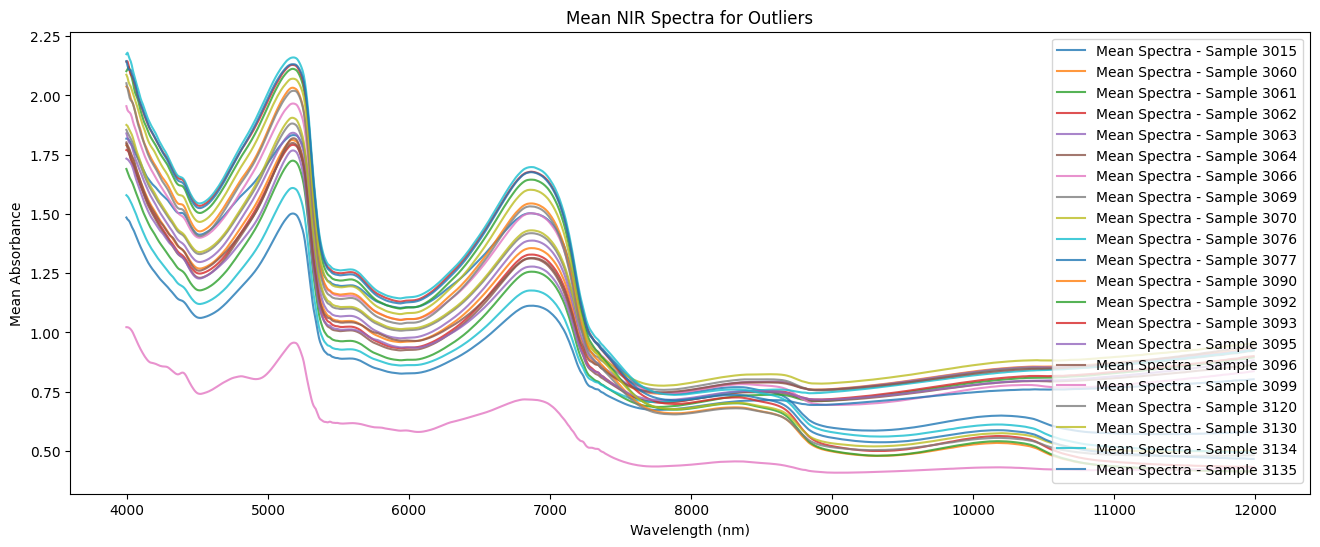

In [148]:
selected_ids = outlier_sample_ids
selected_data = df[df["SampleID_Base"].isin(selected_ids)].copy()

non_spectral_cols = ["SampleID_Base", "Spectral_Round", "Moisture", "Outlier_Flag"]
selected_data = selected_data.drop(columns=[col for col in non_spectral_cols if col in selected_data.columns])

mean_spectra = df[df["SampleID_Base"].isin(selected_ids)].groupby("SampleID_Base").mean()

mean_spectra = mean_spectra.drop(columns=[col for col in non_spectral_cols if col in mean_spectra.columns])

wavelengths = mean_spectra.columns.astype(float)

plt.figure(figsize=(16, 6))
for sample_id, row in mean_spectra.iterrows():
    plt.plot(wavelengths, row, alpha=0.8, label=f"Mean Spectra - Sample {sample_id}")

plt.xlabel("Wavelength (nm)")
plt.ylabel("Mean Absorbance")
plt.title("Mean NIR Spectra for Outliers")
plt.legend()
plt.show()


##Data Cleaning

In this section, outliers are removed from the set and values are smoothed with the Savitsky-Golay filter.

###Removing outliers


Outliers are removed from the data frame to exclude possible noise and data contamination.

In [149]:
#remove outliers from df
df = df[~df['SampleID_Base'].isin(outlier_sample_ids)]

df = df.drop(columns=["Outlier_Flag"], errors="ignore")

df.head()

,SampleID_Base,Spectral_Round,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,...,4057.888,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture
ID,,,,,,,,,,,,,,,,,,,,,
1,3001,0,0.430391,0.430351,0.430570,0.430974,0.431129,0.430807,0.430425,0.430264,...,1.042346,1.052940,1.062511,1.070474,1.077419,1.082571,1.084933,1.086961,1.088756,24.933532
2,3001,1,0.418378,0.418387,0.418783,0.418983,0.418721,0.418339,0.417951,0.417494,...,1.017335,1.027128,1.036592,1.043992,1.049032,1.051711,1.052812,1.054065,1.055364,24.933532
3,3001,2,0.446782,0.446930,0.446840,0.446419,0.446009,0.445715,0.445539,0.445537,...,1.053265,1.061849,1.070649,1.079960,1.088810,1.094708,1.098719,1.100796,1.099144,24.933532
4,3001,3,0.434038,0.433805,0.433692,0.433850,0.433912,0.433757,0.433515,0.433327,...,1.020629,1.029372,1.038613,1.047470,1.053009,1.054695,1.054589,1.053924,1.053708,24.933532
5,3001,4,0.451491,0.451441,0.451692,0.451816,0.451755,0.451595,0.451293,0.451114,...,1.013404,1.023107,1.030855,1.036464,1.042622,1.049984,1.055300,1.055122,1.052386,24.933532


In [150]:
print(f"Moisture Range: {df['Moisture'].min()} to {df['Moisture'].max()}")
print(f"Mean Moisture: {df['Moisture'].mean():.2f}")
print(f"Standard Deviation: {df['Moisture'].std():.2f}")

Moisture Range: 17.981283422459878 to 68.34327050778491
Mean Moisture: 42.28
Standard Deviation: 12.50


###Smoothing with the Savitsky-Golay filter

This allows us to keep the important features while preserving the important spectral features.

Parameters:
- window length: amount of points used in smoothing
- polyorder: polynomial fitting degree (1=linear, 2=quadratic, 3+= higher-order polynomials)


In [151]:
from scipy.signal import savgol_filter

non_spectral_cols = ["SampleID_Base", "Spectral_Round", "Moisture"]
spectral_cols = [col for col in df.columns if col not in non_spectral_cols]

spectral_data = df[spectral_cols].values.astype(np.float64)

#Savitsky-Golay filter, applied row-vise for each sample's different spectrums
smoothed_spectra = np.apply_along_axis(lambda x: savgol_filter(x, window_length=7, polyorder=2), axis=1, arr=spectral_data)

df_smooth = df.copy()
df_smooth[spectral_cols] = smoothed_spectra.astype(np.float64)

df_smooth.info()
df_smooth.head()

<class 'pandas.core.frame.DataFrame'>
Index: 645 entries, 1 to 949
Columns: 1040 entries, SampleID_Base to Moisture
dtypes: float64(1038), int64(2)
memory usage: 5.1 MB


,SampleID_Base,Spectral_Round,11988.51,11980.8,11973.08,11965.37,11957.66,11949.94,11942.23,11934.51,...,4057.888,4050.173,4042.459,4034.744,4027.03,4019.315,4011.601,4003.886,3996.171,Moisture
ID,,,,,,,,,,,,,,,,,,,,,
1,3001,0,0.430203,0.430551,0.430783,0.430898,0.430969,0.430825,0.430532,0.430220,...,1.042909,1.052727,1.062218,1.070708,1.077273,1.081994,1.085526,1.087605,1.088232,24.933532
2,3001,1,0.418256,0.418609,0.418800,0.418830,0.418734,0.418366,0.417908,0.417564,...,1.017542,1.027369,1.036347,1.043710,1.048727,1.051586,1.053825,1.054813,1.054548,24.933532
3,3001,2,0.446913,0.446819,0.446662,0.446444,0.446051,0.445725,0.445563,0.445538,...,1.052941,1.062004,1.071178,1.080104,1.088214,1.094801,1.098595,1.100188,1.099580,24.933532
4,3001,3,0.433924,0.433899,0.433863,0.433817,0.433828,0.433731,0.433547,0.433401,...,1.020633,1.029937,1.039020,1.046847,1.052241,1.054666,1.055849,1.055128,1.052502,24.933532
5,3001,4,0.451388,0.451599,0.451723,0.451759,0.451742,0.451527,0.451284,0.451234,...,1.013642,1.022638,1.030221,1.037046,1.043764,1.049795,1.052965,1.054290,1.053769,24.933532


##Train, Validation and Test Split

The training, validating and testing sets are split at this point. As all spectral rounds are used, the sets are derived so that each ID is not present in other sets to prevent data leakage.

In [152]:
from sklearn.model_selection import train_test_split

unique_samples = df_smooth["SampleID_Base"].unique()

#70/15/15 split
train_samples, temp_samples = train_test_split(unique_samples, test_size=0.3, random_state=42)
val_samples, test_samples = train_test_split(temp_samples, test_size=0.5, random_state=42)

df_train = df_smooth[df_smooth["SampleID_Base"].isin(train_samples)]
df_val = df_smooth[df_smooth["SampleID_Base"].isin(val_samples)]
df_test = df_smooth[df_smooth["SampleID_Base"].isin(test_samples)]

X_train = df_train[spectral_cols].values
y_train = df_train["Moisture"].values

X_val = df_val[spectral_cols].values
y_val = df_val["Moisture"].values

X_test = df_test[spectral_cols].values
y_test = df_test["Moisture"].values

print(f"Train set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]} samples, {X_val.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")


Train set: 444 samples, 1037 features
Validation set: 99 samples, 1037 features
Test set: 102 samples, 1037 features


##Scaling

The sets are scaled for PLS Regression and PCA analysis.

In [153]:
from sklearn.preprocessing import StandardScaler

#scale training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

#apply scaler to other sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


##Models + Additional Pre-processing

###Model 1: PLSRegression

PCA is not applied for PLSRegression, as it handles dimensionality reduction on it's own.

In [154]:
from sklearn.cross_decomposition import PLSRegression

# Initialize PLS Regression model
pls = PLSRegression(n_components=15)

# Fit the model on the training data
pls.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pls.predict(X_val)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate the model
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

# Print the results
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 3.0051818880058656
Root Mean Squared Error: 3.8250680843201823
R-squared: 0.8861622211450534


In [155]:
from sklearn.cross_decomposition import PLSRegression

# Initialize PLS Regression model
pls = PLSRegression(n_components=15)

# Fit the model on the training data
pls.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pls.predict(X_test)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 2.176719410911656
Root Mean Squared Error: 2.7198134067641653
R-squared: 0.9375210311886691


In [156]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

r2_scores_pls = cross_val_score(pls, X_train, y_train, cv=5, scoring='r2')
rmse_scores_pls = np.sqrt(-cross_val_score(pls, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

print(f"Cross-Validation Results (PLSRegression):")
print(f"Mean R² Score: {np.mean(r2_scores_pls):.4f}")
print(f"Mean RMSE Score: {np.mean(rmse_scores_pls):.4f}")

print("R² scores for each fold:", r2_scores_pls)

pls_r2 = np.mean(r2_scores_pls)
pls_rmse = np.mean(rmse_scores_pls)

Cross-Validation Results (PLSRegression):
Mean R² Score: 0.8911
Mean RMSE Score: 3.4590
R² scores for each fold: [0.96417074 0.82243432 0.86630828 0.90927406 0.89328315]


###Pre-processing: PCA

At this point, principal component analysis is applied to the training, validating and testing sets, as Support Vector Machines and Neural Networks benefit from dimensionality reduction.

In [157]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"PCA Explained Variance: {explained_variance:.4f}")


PCA Explained Variance: 1.0000


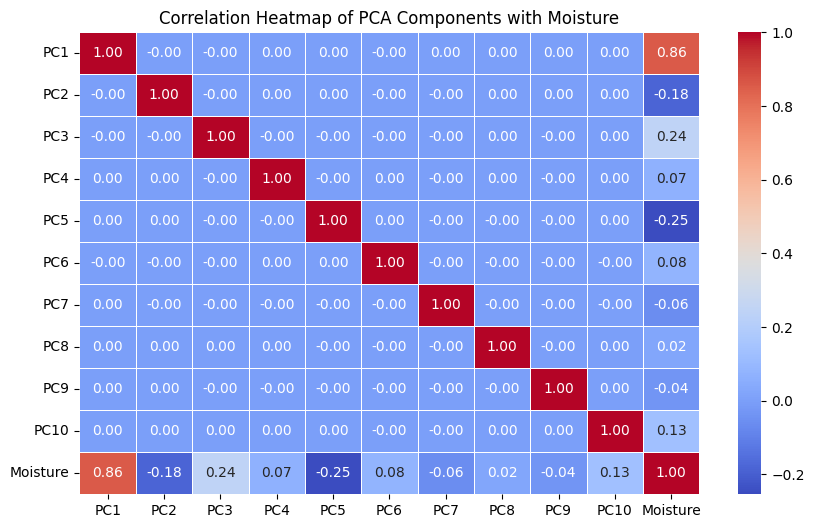

In [158]:
import seaborn as sns

# Create a DataFrame with PCA components and Moisture
df_pca_train = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(10)])
df_pca_train["Moisture"] = y_train

correlation_matrix = df_pca_train.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of PCA Components with Moisture")
plt.show()


###Model 2: SVR

In [159]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=1700, epsilon=0.05)

svr.fit(X_train_pca, y_train)

y_pred = svr.predict(X_val_pca)

r2 = r2_score(y_val, y_pred)
print(f'R²: {r2}')


R²: 0.894028224515059


In [160]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=1700, epsilon=0.05)

svr.fit(X_train_pca, y_train)

y_pred = svr.predict(X_test_pca)

r2 = r2_score(y_test, y_pred)
print(f'R²: {r2}')


R²: 0.8754721161708616


In [161]:
r2_scores_svr = cross_val_score(svr, X_train_pca, y_train, cv=5, scoring='r2')
rmse_scores_svr = np.sqrt(-cross_val_score(svr, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error'))

print(f"Cross-Validation Results (SVR):")
print(f"Mean R² Score: {np.mean(r2_scores_svr):.4f}")
print(f"Mean RMSE Score: {np.mean(rmse_scores_svr):.4f}")

print("R² scores for each fold:", r2_scores_svr)

svr_r2 = np.mean(r2_scores_svr)
svr_rmse = np.mean(rmse_scores_svr)

Cross-Validation Results (SVR):
Mean R² Score: 0.7679
Mean RMSE Score: 5.0083
R² scores for each fold: [0.83579723 0.56820434 0.83605354 0.86480687 0.73473191]


###Model 3: RNN

In [162]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Normalize X (PCA features)
X_train_scaled = feature_scaler.fit_transform(X_train_pca)
X_val_scaled = feature_scaler.transform(X_val_pca)
X_test_scaled = feature_scaler.transform(X_test_pca)

# Normalize y (Moisture)
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()


In [163]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

#scale features
X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_val_rnn = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

#scale target variable
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

#model
model = Sequential([
    SimpleRNN(units=128, return_sequences=True),
    Dropout(0.3),
    SimpleRNN(units=32),
    Dense(1, activation='linear')
])


# Compile the model
model.compile(optimizer=Adam(), loss='mean_absolute_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_rnn, y_train_scaled, epochs=30, batch_size=32, validation_data=(X_val_rnn, y_val_scaled))

# Evaluate the model
loss, mae = model.evaluate(X_test_rnn, y_test_scaled)
print(f"Test Loss: {loss}, Test MAE: {mae}")



Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.2899 - mae: 0.2899 - val_loss: 0.1573 - val_mae: 0.1573
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1346 - mae: 0.1346 - val_loss: 0.0699 - val_mae: 0.0699
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1069 - mae: 0.1069 - val_loss: 0.1183 - val_mae: 0.1183
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0996 - mae: 0.0996 - val_loss: 0.0826 - val_mae: 0.0826
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0855 - mae: 0.0855 - val_loss: 0.0841 - val_mae: 0.0841
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0843 - mae: 0.0843 - val_loss: 0.0822 - val_mae: 0.0822
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0784 - mae: 0.0784 - val_loss: 0.0737 - val_mae: 0.0737
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0695 - mae: 0.0695 - val_loss: 0.0658 - val_mae: 0.0658
Epoch 9/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.079

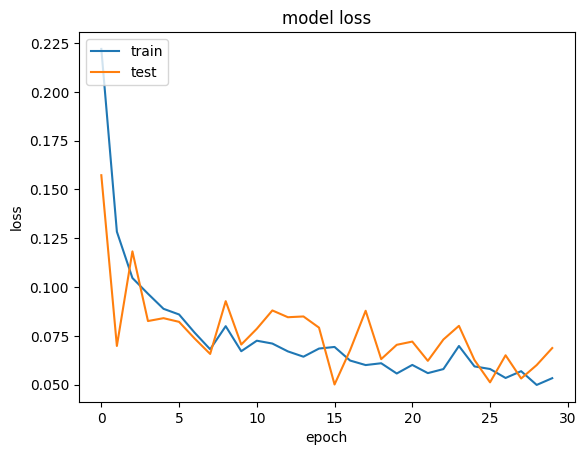

In [164]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [165]:
y_pred_scaled = model.predict(X_test_rnn)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

rnn_r2 = r2_score(y_test, y_pred)
rnn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {rnn_r2}")
print(f"RMSE Score: {rnn_rmse:.4f}")

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
R² Score: 0.9119841719979309
RMSE Score: 3.2281


##Comparisons

In [166]:
results_df = pd.DataFrame({
    "Model": ["PLSRegression", "SVR", "RNN"],
    "R² Score": [pls_r2, svr_r2, rnn_r2],
    "RMSE Score": [pls_rmse, svr_rmse, rnn_rmse]
})

results_df

,Model,R² Score,RMSE Score
0,PLSRegression,0.891094,3.458960
1,SVR,0.767919,5.008347
2,RNN,0.911984,3.228142
